### Articles analysis

In this part, we explored various features across all articles. We collected data on title length, high-frequency words, and titles containing years, hypothesizing that these factors might influence path selection in the game.

In [44]:
import pandas as pd
from urllib.parse import unquote

articles = pd.read_csv('data/wikispeedia_paths-and-graph/articles.tsv', 
                      sep='\t', 
                      comment='#', 
                      header=None,
                      names=['article'])
# unquote the titles
articles = articles.map(unquote)
articles.head()

,article
0,Áedán_mac_Gabráin
1,Åland
2,Édouard_Manet
3,Éire
4,Óengus_I_of_the_Picts


In [45]:
# print the shape
print(f'articles.shape: {articles.shape}')

articles.shape: (4604, 1)


In [46]:
# print the frequency of each word occurred in the titles
articles['article'].str.split('_').explode().value_counts()

article
of          431
the         126
The          73
and          64
United       48
           ... 
Lloyd         1
Francium      1
Goya          1
Assisi        1
Zulu          1
Name: count, Length: 5585, dtype: int64

Among the high-frequency words, meaningful terms such as "United," "History," "England," and "War" appeared frequently. This may indicate a selection bias in the data or reflect topics that attract more attention. 

In [47]:
# the length of titles may affect human's preference
articles['article'].str.len().describe()

count    4604.000000
mean       13.637489
std         7.777092
min         2.000000
25%         8.000000
50%        12.000000
75%        17.000000
max        83.000000
Name: article, dtype: float64

In [48]:
# the titles with specified year may affect human's preference
contain_year = articles[articles['article'].str.contains(r'\b\d{4}\b')]
print(f'Counts: {len(contain_year)}\n{contain_year}')

Counts: 40
                                  article
511             Battle_of_Smolensk_(1943)
515               Battle_of_Warsaw_(1920)
520            Battle_of_the_Somme_(1916)
1368          Elizabethan_Poor_Law_(1601)
1961        History_of_Poland_(1945–1989)
1962      History_of_Portugal_(1777–1834)
2040                Hurricane_Alex_(2004)
2044               Hurricane_Danny_(1997)
2047             Hurricane_Edouard_(1996)
2048             Hurricane_Epsilon_(2005)
2049               Hurricane_Felix_(1995)
2054                Hurricane_John_(1994)
2055                Hurricane_John_(2006)
2058               Hurricane_Marty_(2003)
2060            Hurricane_Philippe_(2005)
2061               Hurricane_Vince_(2005)
2427         Laws_in_Wales_Acts_1535–1542
3290     Polish–Muscovite_War_(1605–1618)
3292     Polish-Muscovite_War_(1605–1618)
3745  Sino-German_cooperation_(1911-1941)
4223            Tropical_Storm_Ana_(2003)
4224          Tropical_Storm_Bilis_(2006)
4225         Tropical_S

Only 40 titles contain years, representing a very small proportion of the dataset.

### Categories analysis
We analyzed the number of categories each article belongs to. 

In [49]:
categories = pd.read_csv('data/wikispeedia_paths-and-graph/categories.tsv',
                        sep='\t',
                        comment='#',
                        header=None,
                        names=['article', 'category'])
# unquote 
categories = categories.map(unquote)
categories.head()

,article,category
0,Áedán_mac_Gabráin,subject.History.British_History.British_Histor...
1,Áedán_mac_Gabráin,subject.People.Historical_figures
2,Åland,subject.Countries
3,Åland,subject.Geography.European_Geography.European_...
4,Édouard_Manet,subject.People.Artists


In [50]:
# print the shape
print(f'categories.shape: {categories.shape}')

categories.shape: (5204, 2)


In [51]:
# Use a list to store the categories for each article 
# and calculate the number of categories
articles_categories = pd.DataFrame(articles, columns=['article'])

category_dict = categories.groupby('article')['category'].apply(list).to_dict()
articles_categories['categories'] = articles_categories['article'].map(category_dict).apply(lambda x: x if isinstance(x, list) else [])
articles_categories['num_categories'] = articles_categories['categories'].apply(len)

len(articles_categories)

4604

In [52]:
articles_categories.head()

,article,categories,num_categories
0,Áedán_mac_Gabráin,[subject.History.British_History.British_Histo...,2
1,Åland,"[subject.Countries, subject.Geography.European...",2
2,Édouard_Manet,[subject.People.Artists],1
3,Éire,"[subject.Countries, subject.Geography.European...",2
4,Óengus_I_of_the_Picts,[subject.History.British_History.British_Histo...,2


In [53]:
# Count the occurrence frequency of each num_categories value
num_categories_counts = articles_categories['num_categories'].value_counts().sort_index().to_frame(name='count')
total = num_categories_counts['count'].sum()
num_categories_counts['percentage'] = (num_categories_counts['count'] / total) * 100
num_categories_counts

,count,percentage
num_categories,,
0,6,0.130321
1,4000,86.880973
2,590,12.814944
3,8,0.173762


Over 85% of articles are assigned to only one category, with a small portion belonging to two, and other counts being close to zero.

### links analysis
In the link analysis phase, we treated the Wikipedia network as a directed graph, calculating in-degree and out-degree distributions and computing PageRank to identify the most structurally influential pages. Pages with higher PageRank scores are typically more central or connected within the network, which may make them attractive choices in a player's navigation path.

Our observations reveal that entities like "United States," "United Kingdom," and "Europe" hold greater influence in terms of both in-degree and PageRank, reflecting their centrality in the network. On the other hand, more generalized articles, such as "Driving on the left or right" and "List of countries," tend to have higher out-degrees. These articles may serve effectively as intermediate nodes, potentially facilitating efficient transitions between more specific topics.

In [54]:
links = pd.read_csv('data/wikispeedia_paths-and-graph/links.tsv',
                     sep='\t',
                     comment='#',
                     header=None,
                     names=['from', 'to'])
# unquote
links = links.map(unquote)
links.head()

,from,to
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland


In [59]:
# The number of edges
len(links)

119882

In [61]:
out_degree = links['from'].value_counts().reset_index()
out_degree.columns = ['article', 'out_degree']
out_degree.head()

,article,out_degree
0,United_States,294
1,Driving_on_the_left_or_right,255
2,List_of_countries,244
3,List_of_circulating_currencies,236
4,List_of_sovereign_states,216


In [66]:
in_degree = links['to'].value_counts().reset_index()
in_degree.columns = ['article', 'in_degree']
in_degree.head()

,article,in_degree
0,United_States,1551
1,United_Kingdom,972
2,France,959
3,Europe,933
4,England,751


In [64]:
degree_df = pd.merge(out_degree, in_degree, on='article', how='outer').fillna(0)
degree_df['out_degree'] = degree_df['out_degree'].astype(int)
degree_df['in_degree'] = degree_df['in_degree'].astype(int)
degree_df.head()

,article,out_degree,in_degree
0,10th_century,26,65
1,11th_century,48,57
2,12th_century,45,85
3,13th_century,34,84
4,14th_century,31,71


In [67]:
# PageRank algorithm
import networkx as nx

G = nx.DiGraph()
edges = list(zip(links['from'], links['to']))
G.add_edges_from(edges)

pagerank_dict = nx.pagerank(G, alpha=0.85)
pagerank_df = pd.DataFrame(list(pagerank_dict.items()), columns=['article', 'pagerank'])
pagerank_df = pagerank_df.sort_values(by='pagerank', ascending=False).reset_index(drop=True)
pagerank_df.head()

,article,pagerank
0,United_States,0.009566
1,France,0.006423
2,Europe,0.006340
3,United_Kingdom,0.006235
4,English_language,0.004865


### path analysis

In [55]:
def load_and_unquote_paths(file_path, column_names):
    df = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=column_names)
    df['path'] = df['path'].map(unquote)
    return df

paths_finished = load_and_unquote_paths('data/wikispeedia_paths-and-graph/paths_finished.tsv',
                                          ['hashedIpAddress','timestamp', 'durationInSec','path','rating'])
paths_finished.head()


,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [56]:
paths_unfinished = load_and_unquote_paths('data/wikispeedia_paths-and-graph/paths_unfinished.tsv',
                                          ['hashedIpAddress','timestamp', 'durationInSec','path','target','type'])
paths_unfinished.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


In [57]:
with open('data/wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt', 'r') as file:
    data = file.readlines()
# remove comment 
data = [line.strip() for line in data if not line.startswith('#') and line.strip()]
# convert the data into a matrix
distance_matrix = [list(line) for line in data]
# convert the matrix into a DataFrame
df = pd.DataFrame(distance_matrix)
df.replace('_', pd.NA, inplace=True)
df = df.apply(pd.to_numeric)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4594,4595,4596,4597,4598,4599,4600,4601,4602,4603
0,0.0,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0,...,4.0,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,2.0
1,NaN,0.0,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,...,4.0,2.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0
2,NaN,NaN,0.0,NaN,NaN,NaN,3.0,3.0,2.0,2.0,...,4.0,3.0,2.0,3.0,4.0,3.0,4.0,3.0,3.0,3.0
3,NaN,NaN,NaN,0.0,NaN,NaN,3.0,3.0,3.0,3.0,...,4.0,2.0,2.0,3.0,4.0,3.0,4.0,4.0,3.0,3.0
4,NaN,NaN,NaN,NaN,0.0,NaN,2.0,2.0,3.0,2.0,...,4.0,2.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0


Mean shortest-path distance: 3.201729547596255
Median shortest-path distance: 3.0


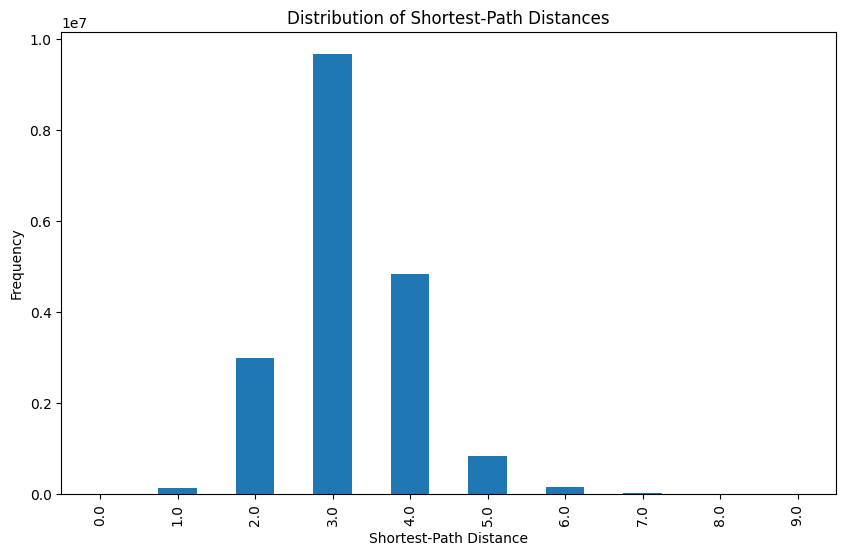

In [58]:
import matplotlib.pyplot as plt

mean_distance = df.stack().mean()
median_distance = df.stack().median()
distance_distribution = df.stack().value_counts().sort_index()

print(f"Mean shortest-path distance: {mean_distance}")
print(f"Median shortest-path distance: {median_distance}")

plt.figure(figsize=(10, 6))
distance_distribution.plot(kind='bar')
plt.title('Distribution of Shortest-Path Distances')
plt.xlabel('Shortest-Path Distance')
plt.ylabel('Frequency')
plt.show()